In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
vod = pd.read_csv('../data/vod89.csv')
vod

,userid,program,score,main_cat,sub_cat,category,rename
0,59879000,소방서 옆 경찰서,0.244476,TV드라마,기타,TV프로그램,소방서옆경찰서
1,59879000,신성한 이혼,0.738281,TV드라마,기타,TV프로그램,신성한이혼
2,59895000,금이야 옥이야,1.000000,TV드라마,기타,TV프로그램,금이야옥이야
3,59900000,2022 역사저널 그날,0.215482,TV 시사/교양,기타,TV프로그램,2022역사저널그날
4,59900000,후궁 제왕의첩,0.292893,영화,멜로,영화,후궁제왕의첩
...,...,...,...,...,...,...,...
1498,67140000,밀수,0.250000,영화,액션/어드벤쳐,영화,밀수
1499,67140000,경남 통영 2부,0.292893,우리동네,연예/오락,TV프로그램,경남통영2부
1500,67140000,잠자는 숲속의 공주,0.292893,키즈,기타,키즈,잠자는숲속의공주
1501,67148000,타요의 씽씽극장 동요2,0.988951,키즈,기타,키즈,타요의씽씽극장동요2


In [3]:
vod_id = pd.read_csv('../data/vod_add_id.csv', index_col=0)
vod_id = vod_id[['rename', 'Category', 'vod_id']]
vod_id.columns = ['rename', 'category', 'vod_id']
vod_id

,rename,category,vod_id
0,와이낫크루뜻밖의여행,TV프로그램,0
1,그레이트뷰티,영화,1
2,해안선,영화,2
3,아는형님,TV프로그램,3
4,베놈,영화,4
...,...,...,...
4710,베놈2:렛데어비카니지,영화,4710
4711,성월동화,영화,4711
4712,다큐인사이트코드블루,TV프로그램,4712
4713,캠프제로베이스원,TV프로그램,4713


In [4]:
vod1 = vod.merge(vod_id, on = ['rename', 'category'], how = 'left')
userid = pd.DataFrame(vod1['userid'].unique())
userid.columns = ['userid']
userid['user_id'] = userid.index

vod1 = vod1.merge(userid, on = ['userid'], how = 'left')
vod1

,userid,program,score,main_cat,sub_cat,category,rename,vod_id,user_id
0,59879000,소방서 옆 경찰서,0.244476,TV드라마,기타,TV프로그램,소방서옆경찰서,2092,0
1,59879000,신성한 이혼,0.738281,TV드라마,기타,TV프로그램,신성한이혼,1190,0
2,59895000,금이야 옥이야,1.000000,TV드라마,기타,TV프로그램,금이야옥이야,784,1
3,59900000,2022 역사저널 그날,0.215482,TV 시사/교양,기타,TV프로그램,2022역사저널그날,572,2
4,59900000,후궁 제왕의첩,0.292893,영화,멜로,영화,후궁제왕의첩,2172,2
...,...,...,...,...,...,...,...,...,...
1498,67140000,밀수,0.250000,영화,액션/어드벤쳐,영화,밀수,2865,329
1499,67140000,경남 통영 2부,0.292893,우리동네,연예/오락,TV프로그램,경남통영2부,4396,329
1500,67140000,잠자는 숲속의 공주,0.292893,키즈,기타,키즈,잠자는숲속의공주,689,329
1501,67148000,타요의 씽씽극장 동요2,0.988951,키즈,기타,키즈,타요의씽씽극장동요2,880,330


In [101]:
vod1.to_csv('../data/vod_score.csv', index = 0)

In [5]:
vod_score = pd.read_csv('../data/vod_score.csv')
vod_score = vod_score[['user_id', 'vod_id', 'score']]
vod_score

,user_id,vod_id,score
0,0,2092,0.244476
1,0,1190,0.738281
2,1,784,1.000000
3,2,572,0.215482
4,2,2172,0.292893
...,...,...,...
1498,329,2865,0.250000
1499,329,4396,0.292893
1500,329,689,0.292893
1501,330,880,0.988951


In [10]:
from sklearn.utils import shuffle
TRAIN_SIZE = 0.75
vod_score = shuffle(vod_score)
cutoff = int(TRAIN_SIZE * len(vod_score))

vod_train = vod_score.iloc[:cutoff]
vod_test = vod_score.iloc[cutoff:]

In [370]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dot, Add, Flatten
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD, Adamax

# variable 초기화
K = 200
mu = vod_train.score.mean()
M = vod_score.user_id.max() + 1
N = vod_score.vod_id.max() + 1

# Defining RMSE measure
def RMSE(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

# Keras model
user = Input(shape = (1,))  # User input
item = Input(shape = (1,))  # Item input
P_embedding = Embedding(M, K, embeddings_regularizer = l2())(user)  # (M, 1, K)
Q_embedding = Embedding(N, K, embeddings_regularizer = l2())(item)  # (N, 1, K)
user_bias = Embedding(M, 1, embeddings_regularizer=l2())(user) # User bias term (M, 1, )
item_bias = Embedding(N, 1, embeddings_regularizer=l2())(item) # Item bias term (N, 1, )

# R = Dot(axes = 2)([P_embedding, Q_embedding])
R = layers.dot([P_embedding, Q_embedding], axes = 2)    # (1, 1, 1)
# R = Add()([R, user_bias, item_bias])
R = layers.add([R, user_bias, item_bias])
R = Flatten()(R)    # (1, 1)

# Model setting
model = Model(inputs = [user, item], outputs = R)
model.compile(
    loss = RMSE,
    optimizer = SGD(),
    metrics = [RMSE]
)
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_15 (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 input_16 (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 embedding_28 (Embedding)    (None, 1, 200)               66400     ['input_15[0][0]']            
                                                                                                  
 embedding_29 (Embedding)    (None, 1, 200)               940200    ['input_16[0][0]']            
                                                                                            

In [371]:
# Model fitting
result = model.fit(
    x = [vod_train.user_id.values, vod_train.vod_id.values],
    y = vod_train.score.values - mu,
    epochs = 300,
    batch_size = 64,
    validation_data = (
        [vod_test.user_id.values, vod_test.vod_id.values],
        vod_test.score.values - mu
    )
)

Epoch 1/300
18/18 [==============================] - 1s 15ms/step - loss: 8.6387 - RMSE: 0.2323 - val_loss: 8.6183 - val_RMSE: 0.2444
Epoch 2/300
18/18 [==============================] - 0s 7ms/step - loss: 8.5773 - RMSE: 0.2317 - val_loss: 8.5577 - val_RMSE: 0.2439
Epoch 3/300
18/18 [==============================] - 0s 7ms/step - loss: 8.5161 - RMSE: 0.2293 - val_loss: 8.4975 - val_RMSE: 0.2434
Epoch 4/300
18/18 [==============================] - 0s 7ms/step - loss: 8.4558 - RMSE: 0.2284 - val_loss: 8.4377 - val_RMSE: 0.2429
Epoch 5/300
18/18 [==============================] - 0s 6ms/step - loss: 8.3964 - RMSE: 0.2284 - val_loss: 8.3784 - val_RMSE: 0.2424
Epoch 6/300
18/18 [==============================] - 0s 5ms/step - loss: 8.3366 - RMSE: 0.2292 - val_loss: 8.3196 - val_RMSE: 0.2419
Epoch 7/300
18/18 [==============================] - 0s 6ms/step - loss: 8.2784 - RMSE: 0.2277 - val_loss: 8.2611 - val_RMSE: 0.2414
Epoch 8/300
18/18 [==============================] - 0s 6ms/step - l

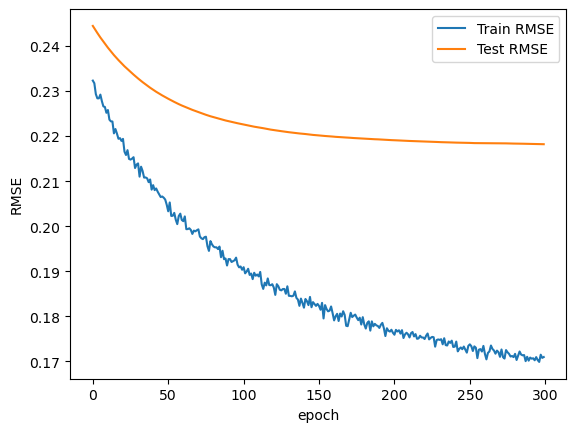

In [372]:
# Plot RMSE
import matplotlib.pyplot as plt
plt.plot(result.history['RMSE'], label = 'Train RMSE')
plt.plot(result.history['val_RMSE'], label = 'Test RMSE')
plt.xlabel('epoch')
plt.ylabel('RMSE')
plt.legend()
plt.show()

In [373]:
user = list(set(vod_train.user_id.values))
result_1 = pd.DataFrame()
for id in user:
    temp = model.predict([np.array([id] * 1503), vod_score.vod_id.values])
    predict_1 = pd.DataFrame(temp.ravel().tolist(), vod_score.vod_id.values).reset_index()
    predict_1.columns = ['vod_id', 'value']
    predict_1 = predict_1.drop_duplicates().sort_values(by = 'value', ascending=False)[0:15].vod_id.values
    predict_1 = pd.DataFrame([predict_1])
    result_1 = pd.concat([result_1, predict_1])

result_1.index = user
result_1 = result_1.apply(lambda x : x.tolist(), axis = 1)
result_1 = result_1.reset_index()
result_1.columns = ['user_id', 'vod_id']
result_1

47/47 [==============================] - 0s 1ms/step


,user_id,vod_id
0,0,"[880, 1156, 296, 1166, 143, 848, 401, 1346, 12..."
1,1,"[880, 296, 1156, 1166, 143, 848, 401, 1346, 12..."
2,2,"[880, 296, 1156, 1166, 143, 848, 401, 1346, 12..."
3,3,"[880, 296, 1156, 1166, 143, 848, 401, 1346, 12..."
4,4,"[880, 296, 1156, 1166, 143, 848, 401, 1346, 12..."
...,...,...
290,326,"[880, 296, 1156, 1166, 143, 848, 401, 1346, 12..."
291,328,"[880, 296, 1156, 1166, 143, 848, 401, 1346, 12..."
292,329,"[880, 1156, 296, 1166, 143, 848, 401, 1346, 12..."
293,330,"[880, 296, 1156, 1166, 143, 848, 401, 1346, 12..."


In [374]:
testdata = vod_test.groupby('user_id')['vod_id'].unique().reset_index()
testdata

,user_id,vod_id
0,0,[1190]
1,2,[3314]
2,4,"[1190, 728]"
3,7,[1673]
4,8,"[3447, 1346, 1944]"
...,...,...
146,312,"[605, 608]"
147,313,[2341]
148,318,"[982, 2342]"
149,321,"[111, 315]"


In [375]:
# precision@15
def precision_k(testdata, recommended_data):
    merge_df = pd.merge(testdata, recommended_data, on='user_id', how = 'left', suffixes=('_actual', '_rec'))
    merge_df = merge_df.dropna()
    precision_value = 0
    for i in range(merge_df.shape[0]):
        temp = len(set(merge_df.iloc[i,1]).intersection(set(merge_df.iloc[i, 2]))) / 15
        precision_value += temp
        
    return precision_value / merge_df.shape[0]

precision_k(testdata, result_1)


0.010526315789473684

In [230]:
result_1.to_csv('../data/result_1.csv', index = 0)
testdata.to_csv('../data/testdata.csv', index = 0)
